In [1]:
import numpy as np
from matplotlib import pyplot as plt
from astropy.cosmology import Planck18
from scipy.special import erf, erfc,erfcx
import scipy
import emcee
import corner
from astropy.table import Table
from astropy.io import fits
import fitsio
import matplotlib as mpl
from multiprocessing import Pool
import torch
#from torch.special import erfcx 


In [2]:
k = Table.read('/pscratch/sd/z/zhaozhon/DATASET/DESI-data/k.csv',format='csv')
indice = np.isnan(k['k_gg']) | np.isinf(k['k_gg']) | np.isnan(k['k_rr']) | np.isinf(k['k_rr'])
k_gg = k['k_gg'][~indice]
k_rr = k['k_rr'][~indice]

In [3]:
file = '/pscratch/sd/z/zhaozhon/DATASET/DESI-data/new_d.fits'
d = Table(fitsio.read(file))
SEL = np.where((d['Z'] > 2.1) & (d['Z'] < 2.8))[0]
apr_mag_g = d['APP_MAG_G'][SEL][~indice]
apr_mag_g_err = d['APP_MAGERR_G'][SEL][~indice]
apr_mag_r = d['APP_MAG_R'][SEL][~indice]
apr_mag_r_err = d['APP_MAGERR_R'][SEL][~indice]
z = d['Z'][SEL][~indice]

In [4]:
print(np.max(apr_mag_g))
print(np.min(apr_mag_g))
print(np.min(apr_mag_g_err))
print()

24.021461
17.057114
0.000622325



In [5]:
d = Planck18.distmod(z).value

In [6]:
'''
def log_likelihood(params,apr_mag, magerr, d, k, m_lim):
    # Filter arrays based on the limiting magnitude
    sigma_I, M_X = params[0],params[1]
    additional_params = params[2:apr_mag.shape[0]]
    # Calculate each term of the log-likelihood
    term1 = -np.log(2*np.pi*magerr*sigma_I)
    term2 = -0.5*((apr_mag-params[2:])/magerr)**2
    term3 = -0.5*((apr_mag-d-k-M_X)/sigma_I)**2
    term4 = -np.log(1/2)-np.log(erfc((apr_mag-m_lim)/np.sqrt(2)/magerr))
    total_log_likelihood = np.sum(term1 +term2+term3+term4)
    #print(total_log_likelihood.shape)
    return total_log_likelihood
    '''

'\ndef log_likelihood(params,apr_mag, magerr, d, k, m_lim):\n    # Filter arrays based on the limiting magnitude\n    sigma_I, M_X = params[0],params[1]\n    additional_params = params[2:apr_mag.shape[0]]\n    # Calculate each term of the log-likelihood\n    term1 = -np.log(2*np.pi*magerr*sigma_I)\n    term2 = -0.5*((apr_mag-params[2:])/magerr)**2\n    term3 = -0.5*((apr_mag-d-k-M_X)/sigma_I)**2\n    term4 = -np.log(1/2)-np.log(erfc((apr_mag-m_lim)/np.sqrt(2)/magerr))\n    total_log_likelihood = np.sum(term1 +term2+term3+term4)\n    #print(total_log_likelihood.shape)\n    return total_log_likelihood\n    '

In [7]:

def log_likelihood(params,apr_mag, magerr, d, k, m_lim):
    # Filter arrays based on the limiting magnitude
    sigma_I, M_X = params[0],params[1]
    additional_params = params[2:apr_mag.shape[0]]
    # Calculate each term of the log-likelihood
    term1 = -torch.log(2*torch.pi*magerr*sigma_I)
    term2 = -0.5*((apr_mag-params[2:])/magerr)**2
    term3 = -0.5*((apr_mag-d-k-M_X)/sigma_I)**2
    term4 = -torch.log(torch.tensor(1/2))-torch.log(erfc((apr_mag-m_lim)/torch.sqrt(torch.tensor(2))/magerr))
    total_log_likelihood = torch.sum(term1 +term2+term3+term4)
    #print(total_log_likelihood.shape)
    return total_log_likelihood
    

In [8]:
m_lim = 22.5
indice = apr_mag_g < m_lim
apr_mag_g = apr_mag_g[indice]
apr_mag_g_err = apr_mag_g_err[indice]
d = d[indice]
k_gg = k_gg[indice]
#params_1 = np.empty(apr_mag_g.shape[0]+2)
#params_1[0],params_1[1] = 1,-24
#params_1[2:] = 22

In [9]:
#-log_likelihood(params_1,apr_mag_g, apr_mag_g_err , d, k_gg, m_lim)

In [10]:
# Initialize parameters, ensuring they require gradients
params = torch.randn(apr_mag_g.shape[0]+2, requires_grad=True)  # Adjust size according to your total number of parameters

# Define optimizer
optimizer = torch.optim.Adam([params], lr=0.003)

apr_mag_g = apr_mag_g.astype(np.float32)
apr_mag_g_err = apr_mag_g_err.astype(np.float32)
d = d.astype(np.float32)
k_gg = k_gg.astype(np.float32)
# Convert your data to PyTorch tensors
apr_mag_g_tensor = torch.from_numpy(apr_mag_g)
apr_mag_g_err_tensor = torch.from_numpy(apr_mag_g_err)
d_tensor = torch.from_numpy(d)
k_gg_tensor = torch.from_numpy(k_gg)
epochs = []
Losses = []
# Optimization loop
for epoch in range(30000):  # Number of epochs, adjust as needed
    optimizer.zero_grad()
    loss = -log_likelihood(params, apr_mag_g_tensor, apr_mag_g_err_tensor, d_tensor, k_gg_tensor,22.5 )
    loss.backward()
    optimizer.step()
    epochs.append(epoch)
    Losses.append(loss.item())
    if epoch % 100 == 0:  # Print loss every 100 epochs
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 769941962752.0
Epoch 100, Loss: 746528964608.0
Epoch 200, Loss: 723849052160.0
Epoch 300, Loss: 701710598144.0
Epoch 400, Loss: 680083062784.0
Epoch 500, Loss: 658949931008.0
Epoch 600, Loss: 638298161152.0
Epoch 700, Loss: 618116284416.0
Epoch 800, Loss: 598393552896.0
Epoch 900, Loss: 579120070656.0
Epoch 1000, Loss: 560286400512.0
Epoch 1100, Loss: 541883301888.0
Epoch 1200, Loss: 523902189568.0
Epoch 1300, Loss: 506334871552.0
Epoch 1400, Loss: 489173188608.0
Epoch 1500, Loss: 472409669632.0
Epoch 1600, Loss: 456037007360.0
Epoch 1700, Loss: 440048091136.0
Epoch 1800, Loss: 424436236288.0
Epoch 1900, Loss: 409194954752.0
Epoch 2000, Loss: 394318118912.0
Epoch 2100, Loss: 379799797760.0
Epoch 2200, Loss: 365634191360.0
Epoch 2300, Loss: 351815794688.0
Epoch 2400, Loss: 338339430400.0
Epoch 2500, Loss: 325199855616.0
Epoch 2600, Loss: 312392351744.0
Epoch 2700, Loss: 299912003584.0
Epoch 2800, Loss: 287754321920.0
Epoch 2900, Loss: 275914915840.0
Epoch 3000, Loss: 2643

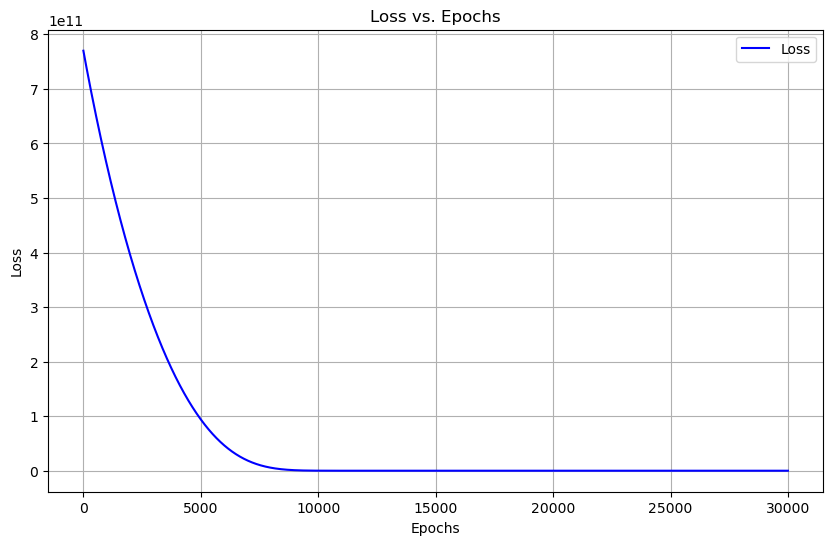

In [15]:
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.plot(epochs, Losses, label='Loss', color='blue')  # Plot Losses vs. epochs
plt.title('Loss vs. Epochs')  # Title of the plot
plt.xlabel('Epochs')  # Label for the x-axis
plt.ylabel('Loss')  # Label for the y-axis
plt.legend()  # Add a legend
plt.grid(True)  # Show grid lines for better readability
plt.show()

In [14]:
# Access optimized parameters
optimized_params = params.data

# If you need to convert to a numpy array for further processing outside PyTorch
optimized_params_numpy = optimized_params.numpy()

print("Optimized Parameters:", optimized_params)
print("As Numpy Array:", optimized_params_numpy)

Optimized Parameters: tensor([  0.9349, -23.9606,  21.4122,  ...,  20.7875,  21.4210,  22.2211])
As Numpy Array: [  0.9348593 -23.960608   21.412235  ...  20.787533   21.420967
  22.221127 ]
